In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch import optim
from sklearn.utils import class_weight
from scipy.stats import *
from torch.autograd import Variable
from tqdm.notebook import tqdm

from save_data import save_data
from sigma import sigma
from get_test_stats import get_test_stats
from size_out import *
from test import test
from train import train
from parameters import *
from read_data import read_data
from preproc_data import *
from label_data import label_data
from split_data import split_data
from detection import *

%load_ext autoreload
%autoreload 2

In [2]:
cyclone_events, data = read_data(path='../data')
# Consider renaming first variable
cyclone_events_data, data, metrics = preproc_data(cyclone_events, metrics=data)
labels, events = label_data(cyclone_events_data.ce2)
train_data, test_data, labels_train, labels_test, train_id, test_id = split_data(data, labels, ratio=0.8)

In [3]:
desc = "Kept batch_size=24. Fixed a, b, c and taught only w."
filename = "Cyclone_bs24_fixed_a_b_c.ipynb"
network_name = filename.split('.')[0]
comment = "Unsuprusingly, accuracy dropped. Suprisingly, not by much."

In [4]:
class MyLayer1(nn.Module):
    
    def __init__(self, w, a, b):
        super().__init__()   
        self.weight = w
        self.a = a
        self.b = b
        
    def forward(self, x):
        # x * w
        x = torch.mul(x, self.weight)
        # x * w - a
        x = torch.sub(x, self.a)
        # (x * w - a) * b
        x = torch.mul(x, self.b)
        return x

class MyLayer2(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.c = c
        
    def forward(self, x):
        x = torch.sum(x, dim=(2, 3))
        x = x.reshape(x.shape[0])
        x = torch.sub(x, self.c)
        return x

class SimpleNN(nn.Module):
    def __init__(self, w, a, b, c):
        super(SimpleNN, self).__init__()
        self.w = nn.Parameter(w, requires_grad=True)  
        self.a = a
        self.b = b
        self.c = c
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = MyLayer1(self.w, self.a, self.b)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = MyLayer2(self.c)
        
    
    def forward(self, x):
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        return x

$$\sigma(\sum(\sigma((w*x - a) * b)) - c)$$

In [5]:
num_epochs = 10
batch_size = 24

w = torch.empty(size=(), dtype=torch.float)
a = torch.empty(size=(), dtype=torch.float)
b = torch.empty(size=(), dtype=torch.float)
c = torch.empty(size=(), dtype=torch.float)

nn.init.constant_(a, val=1)
nn.init.constant_(b, val=50)
nn.init.constant_(w, val=0.5)
nn.init.constant_(c, val=2)

cnn = SimpleNN(w, a, b, c)

y = torch.tensor(list(labels_train))
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights=torch.tensor(class_weights, dtype=torch.double)
print(class_weights)
loss_func = nn.BCEWithLogitsLoss(pos_weight=class_weights[1]/class_weights[0], reduction='mean') 
optimizer = optim.Adam(cnn.parameters(), lr = 0.0001)  

tensor([ 0.5117, 21.8943], dtype=torch.float64)


In [6]:
hyperparameters = (batch_size, w.item(), a.item(), b.item(), c.item())

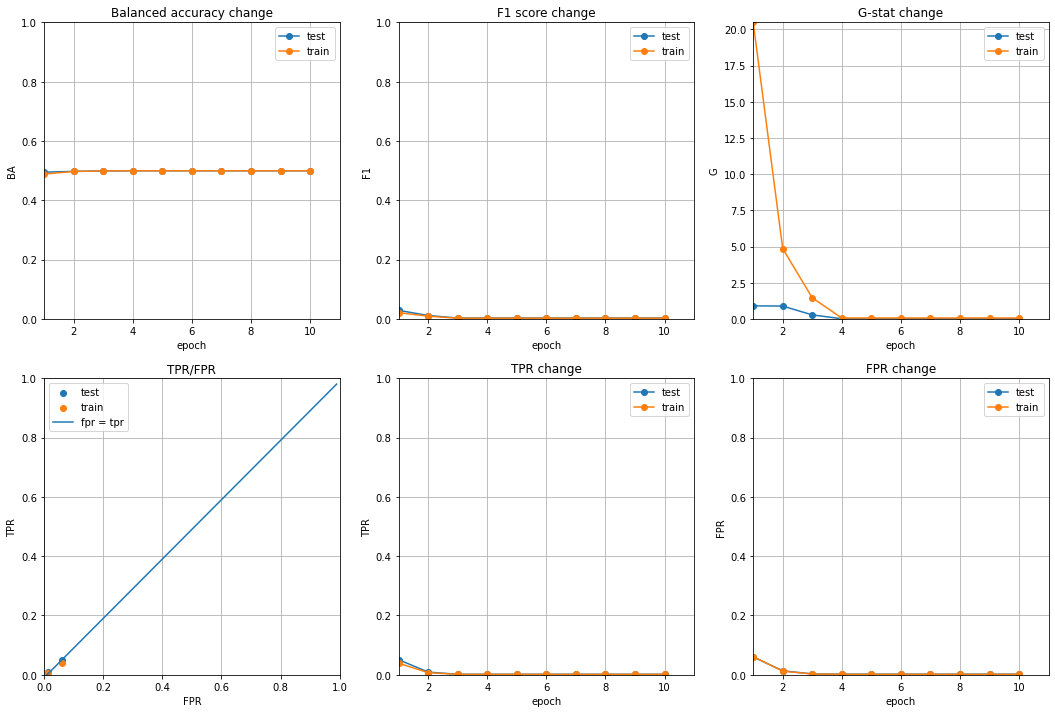

In [7]:
auc_test, auc_train = train(cnn, batch_size, num_epochs, train_data, labels_train, loss_func, optimizer, (test_data, labels_test), draw=False, step_test=True, )

In [8]:
resulting_hyperparameters = [param.data.item() for name, param in cnn.named_parameters()]

tp_test, tn_test, fp_test, fn_test, sigmas, results_test = test(cnn, test_data, labels_test)
test_stats = get_test_stats(test_data.shape[2], tp_test, tn_test, fp_test, fn_test, sigmas, print_res=False)

tp_train, tn_train, fp_train, fn_train, sigmas, results_train = test(cnn, train_data, labels_train)
train_stats = get_test_stats(train_data.shape[2], tp_train, tn_train, fp_train, fn_train, sigmas, print_res=False)

trains_stat_vals = list(vars(train_stats).values())
test_stat_vals = list(vars(test_stats).values())

export_stats = [(item_train, item_test) for (item_train, item_test) in zip(trains_stat_vals, test_stat_vals)]
network_params = NetworkParams(network_name, desc, filename, hyperparameters, resulting_hyperparameters, export_stats, auc_train, auc_test, comment)
network_params.save()

display_data = DisplayData(test_stats.conf_matrix, train_stats.conf_matrix)

In [9]:
image_data_mx, image_data_int = map_ids_to_color(train_id, test_id, results_train, results_test)
marked_events = map_events_to_color(events, train_id, test_id, results_train, results_test)
draw_colormesh_by_tick(image_data_mx, save=True, filename=network_name, display_data=display_data)
draw_colormesh_by_event(marked_events, save=True, filename=network_name, display_data=display_data)